# TOP MUSIC HITS - Proiect Big Data
Scopul acestui proiect este de a incerca prezicerea popularitatii unor cantece in functie de caracteristicile acestora. Acesta poate fi folosit pentru analizarea datelor si oferirea de recomandari artistilor interesati sa produca un nou hit. De asemenea, inaintea incercarii prezicerii popularitatii, setul de date va fi analizat pe cateva caractaeristici pentru a vedea ce preferinte muzicale ajuta un cantec sa ajunga in top.

Setul de date se numește songs_normalize și conține 18 coloane si 2000 de intrari reprezentand hiturile din anii 2000 - 2019 de pe platforma Spotify. Pentru o mai buna intelegere a setului de date voi prezenta coloanele si semnificatiile acestora mai jos:


*  **artist**: numele artistului
*  **song**: numele piesei
*  **duration_ms**: durata piesei in milisecunde
*  **explicit**: versurile sau continutul unui cantec contin unul sau mai multe cuvinte/secvente care ar putea fi considerate jignitoare sau nepotrivite pentru copii
*  **year**: anul lansarii piesei.
*  **popularity**: cu cat valoarea este mai mare, cu atat melodia este mai populara
*  **danceability**: descrie cat de potrivita este o piesa pentru dans, pe baza unei combinatii de elemente muzicale, inclusiv tempo, stabilitatea ritmului, puterea ritmului si regularitatea generala, unde valoarea de 0,0 este cea mai putin dansabila si 1,0 este cea mai dansabila
*  **energy**: o valoare intre 0,0 si 1,0 ce reprezinta o masura perceptiva a intensitatii si a activitatii
*  **key**: cheia in care se afla melodia. Se mapeaza folosind notatia standard Pitch Class. De exemplu: 0 = C, 1 = C♯/D♭, 2 = D etc. Daca nu a fost detectata nicio cheie, valoarea este -1 
*  **loudness**: volumul total al unei piese în decibeli (db). Valorile sonore sunt mediate pe durat intregii piese si sunt utile pentru a compara intensitatea relativa a acestora. Valorile variaza de obicei intre -60 și 0 db.
*  **mode**: indica modalitatea (major sau minor) a unei piese. Major este reprezentat de 1 si minor este 0.
*  **speechiness**: detectează prezenta cuvintelor rostite intr-o piesa. Cu cat inregistrarea are mai multe cuvinte (exemplu: talk-show, carte audio), cu atat valoarea atributului este mai aproape de 1.0. Valorile de peste 0,66 descriu piese care sunt probabil formate in intregime din cuvinte. Valorile intre 0,33 și 0,66 descriu piese care pot conține muzica dar si vorbire, inclusiv cazuri precum muzica rap. Valorile sub 0,33 reprezintă cel mai probabil muzica si alte melodii care nu contin cuvinte
*  **acousticness**: are valori de la 0.0 la 1.0, unde 1.0 reprezintă o incredere ridicată ca pista este acustica
*  **instrumentalness**: prezice daca o piesa nu contine voce. Sunetele „Ooh” si „aah” sunt tratate ca instrumentale in acest context. Melodiile rap sau vorbite sunt în mod clar „vocale”. 1.0 indica cea mai mare probabilitatea ca piesa sa nu contina cuvinte (valorile de peste 0.5 sunt menite sa indice piese instrumentale, dar siguranta creste cand valoarea se apropie de 1.0) 
*  **liveness**: detectează prezenta unei audiente. O valoare peste 0.8 indica o probabilitate mare ca piesa sa fie live
*  **valence**: o valoare de la 0.0 la 1.0 care descrie pozitivitatea muzicala transmisa de o piesa. Piesele cu valenta ridicata suna mai pozitiv (fericit, vesel, euforic), in timp ce piesele cu valenta scazuta suna mai negativ (trist, deprimat, furios)
*  **tempo**: tempo-ul total estimat al unei piese in batai pe minut (BPM). 
*  **genre**: genul piesei

Etapele proiectului:
1. Importarea librariilor si creearea sesiunii spark
2. Importarea setului de date din fisierul CSV aflat in Google Drive
3. Prezentarea datelor (coloane, numar de intrari, cateva statistici)
4. Verificarea, prelucrarea si pregatirea datelor
     *   Verificarea pe coloane a existentei valorilor null
     *   Verificarea datelor din coloana 'genre'
     *   Transformarea variabilei 'genre' de tip string in variabila categoriala
     *   Creearea unui vector de 'features' folosind VectorAssembler
5. Selectia modelelor: 
    *  Linear Regression
    *  Random Forest + creearea si utilizarea unui pipeline
    *  Gradient-boosted tree regression + creearea si utilizarea unui pipeline
6. Utilizarea unui model DL - utilizand Tensorflow





### 1. Importarea librariilor si creearea sesiunii spark

In [1]:
# Se instaleaza pyspark

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 199 kB 53.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=712c37dd208548e3672909d16f9faac4dc377786d24bea52c4199e602d4c9d5d
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [118]:
# Se importa librariile ce vor fi folosite in proiect

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pyspark.sql import functions
import pyspark.sql.functions as f
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [3]:
# Se creeaza o sesiune spark: "music_hits"
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('music_hits').getOrCreate()

### 2. Importarea setului de date din fisierul CSV aflat in Google Drive

In [4]:
# Se importa datele din fisierul CSV aflat pe Google Drive
drive.mount('/content/drive')
folder = "/content/drive/MyDrive/Big Data/"
df = spark.read.csv(folder + 'songs_normalize.csv', inferSchema=True, header=True)

Mounted at /content/drive


### 3.Prezentarea datelor
Se vor afisa: schema datelor, numarul de intrari din setul de date, coloanele existente, afisarea primelor 20 de intrari, o statistica si cateva ploturi (matricea de corelatii si histograme). Primul plot va fi reprezentat de matricea de corelatii si va contine toate atributele din setul de date, al doilea plot va fi o histograma ce va prezenta distributia variabilei 'popularity' iar al treilea plot va fi o histograma ce va analiza variabila 'valenta'.


In [5]:
# Se afiseaza schema datelor
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- song: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- year: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- genre: string (nullable = true)



In [6]:
# Se afiseaza numarul de intrari din setul de date
df.count()

2000

In [7]:
# Se afiseaza coloanele din setul de date
df.columns

['artist',
 'song',
 'duration_ms',
 'explicit',
 'year',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genre']

In [8]:
# Se afiseaza datele (primele 20 de randuri)
df.show()

+---------------+--------------------+-----------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+
|         artist|                song|duration_ms|explicit|year|popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|               genre|
+---------------+--------------------+-----------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+
| Britney Spears|Oops!...I Did It ...|     211160|   false|2000|        77|       0.751| 0.834|  1|  -5.444|   0|     0.0437|         0.3|         1.77E-5|   0.355|  0.894| 95.053|                 pop|
|      blink-182|All The Small Things|     167066|   false|1999|        79|       0.434| 0.897|  0|  -4.918|   1|     0.0488|      0.0103|             0.0|   0.612|  0.684|148.726|           r

In [9]:
# Se va afisa o scurta statistica asupra setului de date
df.summary().show()

+-------+-------------+--------------------+------------------+-----------------+----------------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+----------------+
|summary|       artist|                song|       duration_ms|             year|      popularity|       danceability|            energy|              key|          loudness|               mode|        speechiness|       acousticness|    instrumentalness|           liveness|           valence|             tempo|           genre|
+-------+-------------+--------------------+------------------+-----------------+----------------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+----------------+
|  coun

In [78]:
# Se face transformarea dataframe-ului in Pandas pentru a putea creea ploturi
df_pandas = df.toPandas()

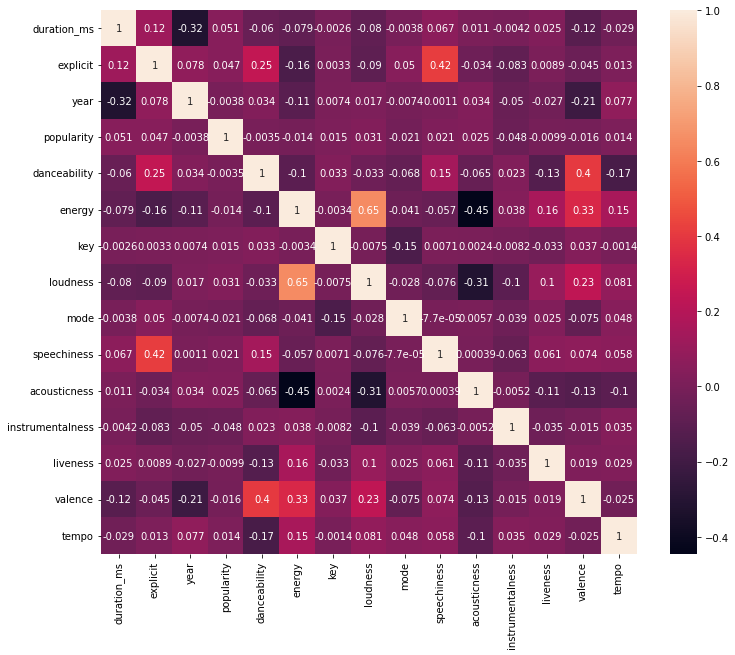

In [12]:
# Se afiseaza matricea de corelatii

plt.figure(figsize=(12,10))
sns.heatmap(df_pandas.corr(),annot=True)

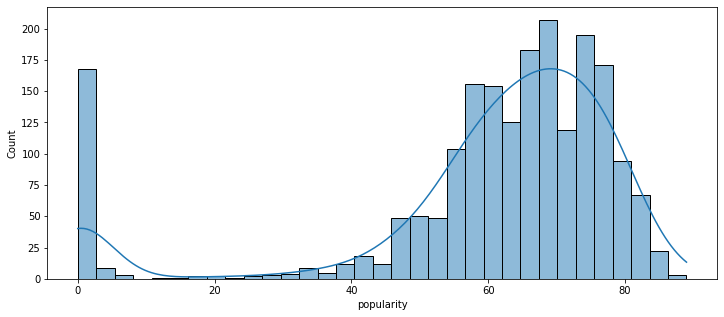

In [68]:
# Histograma pentru distributia coloanei 'popularity'

plt.figure(figsize=(12, 5))
sns.histplot(df_pandas['popularity'], kde=True)

(array([ 56., 114., 163., 235., 261., 304., 275., 252., 209., 131.]),
 array([0.0381 , 0.13159, 0.22508, 0.31857, 0.41206, 0.50555, 0.59904,
        0.69253, 0.78602, 0.87951, 0.973  ]),
 <a list of 10 Patch objects>)

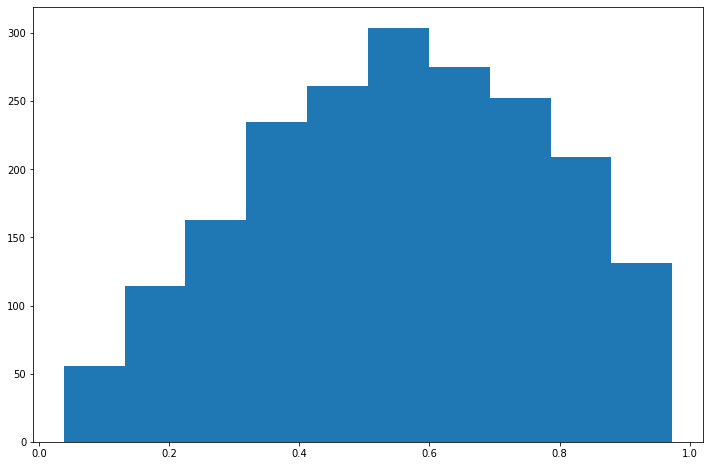

In [13]:
# Histograma pentru variabila 'valence'

plt.figure(figsize=(12,8))
plt.hist(df_pandas['valence'], bins=10)

In histograma realizata pentru variabila 'valence' se poate observa ca predomina in top cantecele cu o valenta ridicata. Asa cum am scris si mai sus, la prezentarea atributelor din setul de date, o valenta crescuta indica de obicei o melodie cu un ton vesel, fericit si euforic, in timp ce o melodie cu valenta scazuta indica un cantec cu ton trist, deprimat, negativ. Deci, uitandu-ne la histograma de mai sus se poate deduce ca majoritatea hiturilor par sa fie melodii cu un ton vesel.

### 4. Verificarea si prelucrarea datelor

  Se vor sterge coloanele'artist' si 'song' fiind considerate irelevante in procesul de predictie ce va urma, apoi se verifica fiecare coloana ramasa pentru a vedea daca exista valori null. De asemenea, se afiseaza valorile din coloana 'genre' si se ia o decizie asupra modului in care vor fi utilizate datele de acolo. Se va folosi StringIndexer pentru transformarea in variabila categoriala a variabilei string 'genre' si se va crea un vector denumit "features", format din coloanele relevante, folosind VectorAssembler.

In [97]:
# Se sterg coloanele 'artist' si 'song'

df = df.drop('artist')
df = df.drop('song')
df.columns

['duration_ms',
 'explicit',
 'year',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genre']

In [14]:
# Se verifica daca exista valori null si se afiseaza cate valori null sunt pentru fiecare coloana

df_agg= df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
df_agg.show()

+------+----+-----------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----+
|artist|song|duration_ms|explicit|year|popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|genre|
+------+----+-----------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----+
|     0|   0|          0|       0|   0|         0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|    0|
+------+----+-----------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----+



Se observa ca nu sunt valori null, deci nu trebuie sterse intrari din setul de date, sau inlocuite in vreun fel datele din coloana respectiva.

In [15]:
# Se obtine numarul de valori pentru coloana genre
df2 = df.groupBy('genre').count()
df2.orderBy(col("count").desc(),col("genre").asc()).show(60)

+--------------------+-----+
|               genre|count|
+--------------------+-----+
|                 pop|  428|
|        hip hop, pop|  277|
|   hip hop, pop, R&B|  244|
|pop, Dance/Electr...|  221|
|            pop, R&B|  178|
|             hip hop|  124|
|hip hop, pop, Dan...|   78|
|                rock|   58|
|           rock, pop|   43|
|    Dance/Electronic|   41|
|         rock, metal|   38|
|          pop, latin|   28|
|           pop, rock|   26|
|               set()|   22|
|hip hop, Dance/El...|   16|
|               latin|   15|
| hip hop, pop, latin|   14|
|    pop, rock, metal|   14|
|                 R&B|   13|
|pop, rock, Dance/...|   13|
|             country|   10|
|  hip hop, pop, rock|    9|
|               metal|    9|
|  pop, Folk/Acoustic|    8|
|        pop, country|    8|
|rock, pop, Dance/...|    8|
|pop, R&B, Dance/E...|    6|
|    rock, pop, metal|    4|
|        hip hop, R&B|    3|
|hip hop, pop, R&B...|    3|
|hip hop, pop, R&B...|    3|
|  Folk/Acoust

Dupa cum se poate observa, exista si valori compuse in tabel, adica intrari care sunt incluse in mai mult de un gen. Avand in vedere faptul ca a doua cea mai numeroasa valoare pentru coloana gen este "hip hop, pop", adica o valoare compusa, si ca exista destul de sus in top intrari ce nu apartin doar unui gen, am ales sa pastrez datele asa, considerand intreaga grupare de mai multe genuri ca reprezentand un singur gen. De asemenea, varaibila gen fiind de tip string va trebui transformata in variabila categoriala pentru a putea fi utilizata mai departe.

In [16]:
#Se va folosi StringIndexer pentru a transformarea in variabila categoriala variabila string 'genre'

indexer = StringIndexer(inputCol="genre", outputCol="genre_cat")
indexed = indexer.fit(df).transform(df)
indexed.columns


['artist',
 'song',
 'duration_ms',
 'explicit',
 'year',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genre',
 'genre_cat']

Mai departe se va forma un vector 'features' utilizand coloanele relevante. Am ales sa includ in acesta toate atributele numerice, deoarece, conform matricei de corelatie, nu se poate spune ca existau valori ce ar fi fost mult mai reprezentative decat altele in relatie cu variabila 'popularitate'.

In [18]:
#Se va forma un vector denumit "features", format din coloanele relevante. 
assembler = VectorAssembler(
  inputCols=['duration_ms',
             'explicit',
             'danceability',
             'energy',
             'key',
             'loudness',
             'mode',
             'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'tempo',
            'genre_cat'],
    outputCol="features")

In [19]:
output = assembler.transform(indexed)

In [20]:
#Se afiseaza coloanele "features" și "popularity" (primele 20)
output.select("features", "popularity").show()

+--------------------+----------+
|            features|popularity|
+--------------------+----------+
|[211160.0,0.0,0.7...|        77|
|[167066.0,0.0,0.4...|        79|
|[250546.0,0.0,0.5...|        66|
|[224493.0,0.0,0.5...|        78|
|[200560.0,0.0,0.6...|        65|
|[253733.0,1.0,0.7...|        69|
|[284200.0,1.0,0.9...|        86|
|[258560.0,0.0,0.7...|        68|
|[271333.0,0.0,0.7...|        75|
|[307153.0,0.0,0.7...|        77|
|[238759.0,0.0,0.6...|         1|
|[268863.0,0.0,0.7...|        56|
|[306333.0,0.0,0.8...|        55|
|[285960.0,0.0,0.5...|        62|
|[294200.0,0.0,0.6...|        61|
|[284000.0,0.0,0.7...|        53|
|[245400.0,0.0,0.7...|        64|
|[214883.0,0.0,0.6...|        73|
|[285426.0,0.0,0.7...|        64|
|[161506.0,1.0,0.9...|        82|
+--------------------+----------+
only showing top 20 rows



### 5. Alegerea si implementarea modelelor

Folosind setul de date ales, se doreste prezicerea popularitatii unor melodii in functie de anumite caracteristici. Pentru rezolvarea acesteia, se vor folosi 3 modele ML. Deoarece problema pusa de mine este una de regresie, modelele ML alese si implementate vor fi de tip regresie.

1. Regresie Liniara

  Primul pas va fi creeare unui data frame pentru regresie, folosid doar coloanele 'features' si 'popularity' apoi se va face o diviziune asupra setului de date. Datele din setul de date vor fi impartite in doua subseturi: unul pentru antrenarea modelului si unul pentru testarea lui, procentele utilizate la impartire fiind 70% pentru cel de antrenare si 30% pentru cel de testare. Se va creea apoi un obiect de tip Linear Regresion, se antreneaza modelul si se testeaza.

2. Random Forest

  Pentru acest model am ales sa creez un nou vector, numit 'features2', in care am utilizat doar variabilele 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'instrumentalness', 'valence' si 'tempo'. Se creeaza un data frame nou, utilizand 'popularity' si 'features2' si se imparte iarasi setul de date in date de antrenare si date de testare, folosind procentul 70% pentru datele de antrenare si 30% pentru cele de testare. Apoi se creeaza un obiect de tip Random Forest Regressor cu coloanele 'popularity' si 'features2' si un pipeline. Se antreneaza modelul utilizand pipeline-ul creeat, apoi se testeaza si se evalueaza rezultatul obtinut.

3. Gradient-boosted tree regression

  Pentru acest model voi folosi acelasi vectpr de features creeat la al doilea model si anume 'features2' si aceleasi seturi de date de antrenament si de testare. Prima data se creeaza un obiect de tipul GBTRegressor si un nou pipeline, apoi se antreneaza modelul folosind pipeline-ul. Se fac predictii pe baza setului de date de test, utilizand modelul antrenat si se evalueaza predictiile.

LINEAR REGRESSION

In [ ]:
# Se creeaza un dataframe doar cu aceste 2 coloane

df_linear_regression = output.select("features", "popularity")

In [ ]:
# Se face o diviziune a setului de date în subseturi pentru antrenare si testare testare. Procentele vor fi 70%, respectiv 30%.
trainData,testData = df_linear_regression.randomSplit([0.7,0.3])

In [ ]:
#Se afiseaza statistici asupra datelor pentru training
trainData.describe().show()

+-------+------------------+
|summary|        popularity|
+-------+------------------+
|  count|              1372|
|   mean|59.498542274052475|
| stddev| 21.72544342726445|
|    min|                 0|
|    max|                89|
+-------+------------------+



In [ ]:
#Se afiseaza statistici asupra datelor pentru test
testData.describe().show()

+-------+------------------+
|summary|        popularity|
+-------+------------------+
|  count|               628|
|   mean|60.689490445859875|
| stddev|20.451149663208614|
|    min|                 0|
|    max|                88|
+-------+------------------+



In [ ]:
# Se creeaza un obiect de tip LinearRegression
lr = LinearRegression(labelCol='popularity')

In [ ]:
# Se antreneaza modelul
lrModel = lr.fit(trainData)

In [ ]:
# Se afiseaza coeficientii si interceptia pentru regresia liniara
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [3.939419358086384e-05,1.9804784664542867,-5.173406349284654,-10.658491042788786,-0.09235787751284606,1.1275811080340679,-1.0185931385987248,1.5441439051619248,5.2077161370692675,-13.160501893233178,-1.9665128313477875,0.8998358772073576,0.0013379322749734548,0.03262993775734032] Intercept: 67.2702220575919


In [ ]:
#Se evalueaza modelul pe datele de testare
results = lrModel.evaluate(testData)

In [ ]:
# Se afiseaza informatiile obtinute dupa evaluare 
print("RMSE: {}".format(results.rootMeanSquaredError))
print("MSE: {}".format(results.meanSquaredError))
print("R2: {}".format(results.r2))

RMSE: 20.773414010086253
MSE: 431.5347296344478
R2: -0.033409387199559326


In [ ]:
# Se afiseaza valorile reziduale
results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|  21.652972661839392|
|  25.077750980152828|
| -50.910914161495775|
|   2.159522545542657|
|   21.73265916605169|
| -12.356734245566123|
| -50.432759355479504|
|  0.9846883744631043|
| -14.566564619892418|
|  -7.801268867453686|
|   8.520262865642117|
|   4.727084495405094|
|-0.14343902533298802|
|   7.210548252080976|
|  21.575182493473086|
|  13.648722525142482|
|   -7.49211244179191|
|  12.566787472630544|
|  22.444600893085067|
|  13.920676963816021|
+--------------------+
only showing top 20 rows



In [ ]:
# Sa se afiseze corelatia intre 'popularity' si 'speechiness'
from pyspark.sql.functions import corr
df.select(corr('popularity','speechiness')).show()


+-----------------------------+
|corr(popularity, speechiness)|
+-----------------------------+
|         0.021162352578132707|
+-----------------------------+



In [ ]:
# Sa se afiseze corelatia intre 'popularity' si 'loudness'
from pyspark.sql.functions import corr
df.select(corr('popularity','loudness')).show()

+--------------------------+
|corr(popularity, loudness)|
+--------------------------+
|      0.030632316459533623|
+--------------------------+



In [ ]:
#Aplicați modelul pe datele de test neetichetate
unlabeled_data=testData.select("features")
predictions = lrModel.transform(unlabeled_data)
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[113000.0,0.0,0.9...| 54.34702733816061|
|[119133.0,1.0,0.8...| 57.92224901984717|
|[129264.0,1.0,0.9...|51.910914161495775|
|[144244.0,0.0,0.8...| 54.84047745445734|
|[149546.0,1.0,0.8...| 57.26734083394831|
|[150533.0,0.0,0.8...| 51.35673424556612|
|[150533.0,0.0,0.8...|50.432759355479504|
|[151640.0,0.0,0.7...|60.015311625536896|
|[151973.0,0.0,0.7...| 57.56656461989242|
|[156773.0,1.0,0.7...|58.801268867453686|
|[157293.0,0.0,0.4...| 57.47973713435788|
|[157643.0,1.0,0.6...|58.272915504594906|
|[161240.0,0.0,0.8...| 56.14343902533299|
|[161746.0,0.0,0.7...|55.789451747919024|
|[161920.0,0.0,0.4...|58.424817506526914|
|[163320.0,1.0,0.8...| 58.35127747485752|
|[164506.0,1.0,0.6...| 56.49211244179191|
|[165440.0,0.0,0.6...|54.433212527369456|
|[165853.0,0.0,0.6...| 55.55539910691493|
|[166373.0,1.0,0.5...| 59.07932303618398|
+--------------------+------------

In [ ]:
testData.show()

+--------------------+----------+
|            features|popularity|
+--------------------+----------+
|[113000.0,0.0,0.9...|        76|
|[119133.0,1.0,0.8...|        83|
|[129264.0,1.0,0.9...|         1|
|[144244.0,0.0,0.8...|        57|
|[149546.0,1.0,0.8...|        79|
|[150533.0,0.0,0.8...|        39|
|[150533.0,0.0,0.8...|         0|
|[151640.0,0.0,0.7...|        61|
|[151973.0,0.0,0.7...|        43|
|[156773.0,1.0,0.7...|        51|
|[157293.0,0.0,0.4...|        66|
|[157643.0,1.0,0.6...|        63|
|[161240.0,0.0,0.8...|        56|
|[161746.0,0.0,0.7...|        63|
|[161920.0,0.0,0.4...|        80|
|[163320.0,1.0,0.8...|        72|
|[164506.0,1.0,0.6...|        49|
|[165440.0,0.0,0.6...|        67|
|[165853.0,0.0,0.6...|        78|
|[166373.0,1.0,0.5...|        73|
+--------------------+----------+
only showing top 20 rows



RANDOM FOREST

In [55]:
#Se creeaza un nou vector, numit 'features2'

assembler = VectorAssembler(
  inputCols=['explicit',
             'danceability',
             'energy',
             'key',
             'loudness',
             'mode',
             'speechiness',
            'instrumentalness',
            'valence',
            'tempo'],
    outputCol="features2")

output2 = assembler.transform(indexed)

In [56]:
# Se creeaza un data frame nou

df_RandomForest = output2.select("features2", "popularity")

In [57]:
# Se imparte iar setul de date in date de antrenare si date de test, cu procente 70% si 30%

trainData,testData = df_RandomForest.randomSplit([0.7,0.3])

In [58]:
#Se afiseaza statistici asupra datelor pentru training

trainData.describe().show()

+-------+----------------+
|summary|      popularity|
+-------+----------------+
|  count|            1389|
|   mean|60.0280777537797|
| stddev|21.2294977374443|
|    min|               0|
|    max|              88|
+-------+----------------+



In [59]:
#Se afiseaza statistici asupra datelor pentru test

testData.describe().show()

+-------+------------------+
|summary|        popularity|
+-------+------------------+
|  count|               611|
|   mean| 59.51882160392799|
| stddev|21.588116553187866|
|    min|                 0|
|    max|                89|
+-------+------------------+



In [60]:
# Se creeaza un obiect de tip Random Forest Regressor cu coloanele 'popularity' si 'features2'

rf = RandomForestRegressor(labelCol = 'popularity',
                            featuresCol = 'features2')

In [61]:
featureIndexer =\
    VectorIndexer(inputCol="features2", outputCol="indexedFeatures").fit(trainData)

pipeline = Pipeline(stages=[featureIndexer, rf])

In [62]:
# Se antreneaza modelul

model = pipeline.fit(trainData)

In [63]:
# Se testeaza si se evalueaza modelul

predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="mae")

mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)

rfModel = model.stages[1]
print(rfModel)

MAE on test data = 14.8176
RandomForestRegressionModel: uid=RandomForestRegressor_c694186409c2, numTrees=20, numFeatures=10


 GRADIENT-BOOSTED TREE REGRESSION

In [64]:
# Se creeaza un obiect de tipul GBTRegressor

gbt = GBTRegressor(labelCol = 'popularity', featuresCol="indexedFeatures", maxIter=10)

#Se creeaza un pipeline nou 

pipeline = Pipeline(stages=[featureIndexer, gbt])

# Se antreneaza modelul
model = pipeline.fit(trainData)

# Se fac predictiile utilizand datele de testare
predictions = model.transform(testData)

# Se evalueaza predictiile utilizand RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)

gbtModel = model.stages[1]
print(gbtModel)

MAE on test data = 16.8647
GBTRegressionModel: uid=GBTRegressor_e5dd1d60dec2, numTrees=10, numFeatures=10


### 6. Utilizarea unui model DL 

Modelul DL va fi de tip regresie si va avea ca scop rezolvarea aceleiasi probleme: prezicerea popularitatii unor melodii.
Pentru acesta se va folosi un data frame de tip pandas din care se va sterge variabila de tip string ('genre') si se vor separa caracteristicile variabilei tinta ('popularity'), apoi se vor imparti datele in date de antrenare si date de testare. Se va aplica un feature scaling; acesta va invata pe datele de antrenare si va fi aplicat pe datele de antrenament si de test. Apoi se va creea o retea neuronala cu o arhitectura adaptata problemelor de tip regresie si se va compila modelul, avand parametrii de pe ultimul strat luati in calcul, aceasta fiind o problema de regresie si nu de clasificare. Se antreneaza modelul pentru 200 de epoci si o dimensiune a batch-ului de 128. La final, se va folosi un grafic pentru a analiza training loss-ul si validation loss-ul si se vor afisa valorile RMSE, MAE si MSLE.

In [103]:
# Se transforma data frame-ul intr-un dat frame de tip pandas
dfdl = df.toPandas()

# Se scoate coloana 'genre'
dfdl = dfdl.drop('genre', axis = 1)

# Se separa caracteristicile variabilei 'popularity'
X = dfdl.drop('popularity', axis = 1)
y = dfdl['popularity']

# Se impart datele in date de antrenare si date de testare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [105]:
# feature scaling
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Se afiseaza forma dataset-urilor de antrenament si de testare

print(X_train.shape)
print(X_test.shape)

(1400, 14)
(600, 14)


In [112]:
# Se creeaza o retea neuronala ce are o arhitectura potrivita unei probleme de tip regresie
model = Sequential()
model.add(Dense(14, activation='relu', input_shape=(14, )))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 14)                210       
                                                                 
 dense_6 (Dense)             (None, 14)                210       
                                                                 
 dense_7 (Dense)             (None, 14)                210       
                                                                 
 dense_8 (Dense)             (None, 14)                210       
                                                                 
 dense_9 (Dense)             (None, 1)                 15        
                                                                 
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Se compileaza modelul 

model.compile(optimizer='adam', loss='mse')

In [115]:
# Se antreneaza modelul pentru 200 de epoci si o dimensiune a batch-ului de 128.

history = model.fit(x=X_train,
                  y=y_train,
                  validation_data=(X_test, y_test),
                  batch_size=128, 
                  epochs=200)

Epoch 1/200
11/11 [==============================] - 0s 5ms/step - loss: 466.5378 - val_loss: 572.9998
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 465.5664 - val_loss: 571.7711
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 463.9656 - val_loss: 567.5698
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 463.5746 - val_loss: 564.6943
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 462.1474 - val_loss: 567.9288
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 461.3585 - val_loss: 567.9556
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 460.0435 - val_loss: 562.5475
Epoch 8/200
11/11 [==============================] - 0s 6ms/step - loss: 459.3377 - val_loss: 562.1736
Epoch 9/200
11/11 [==============================] - 0s 5ms/step - loss: 458.7121 - val_loss: 562.4395
Epoch 10/200
11/11 [==============================] - 0s 5ms/step - loss:

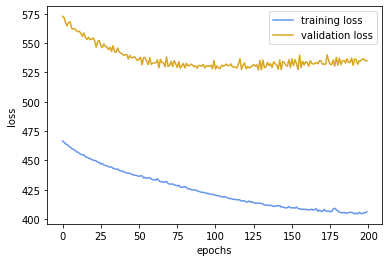

In [116]:
# Se analizeaza pe grafic training loss-ul si validation loss-ul

plt.plot(history.history['loss'], c='cornflowerblue', label='training loss')
plt.plot(history.history['val_loss'], c='goldenrod', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss');

In [119]:
# Calcularea si afisarea valorilor RMSE, MAE, MSLE

y_pred = model.predict(X_test).reshape((-1, ))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
msle = mean_squared_log_error(y_test, y_pred)

print(f'RMSE: {rmse} - MAE: {mae} - MSLE: {msle}')

RMSE: 23.130289447348677 - MAE: 15.395006917317708 - MSLE: 1.7371994692508974


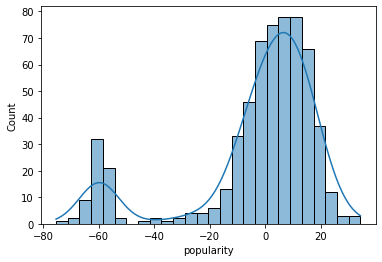

In [121]:
# Se calculeaza vectorul de valori reziduale (valori reale - predictii)  
errors = y_test - y_pred

# Histograma cu estimarea densitatii acestor erori.
sns.histplot(x=errors, kde=True);